<div class='alert alert-success'>
    <h1>Qiskit Tutorial, Part 2: Gates </h1>
    <h4>Yen Lee Loh; started 2023-4-5, edited 2023-4-7 </h4>
</div>

<div class="alert alert-info"><h2>  Setup  </h2></div>

This is a Markdown cell with LaTeX definitions.  Please run it.
$\newcommand{\mean}[1]{\langle #1 \rangle}$
$\newcommand{\ket}[1]{\lvert #1 \rangle}$
$\newcommand{\adag}{a^\dagger}$

In [3]:
import numpy as np; from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import qiskit,qiskit_aer
import qiskit.visualization as qisvis
from qiskit.providers.fake_provider import fake_provider
vigoBackend = fake_provider.FakeVigo()
rng = random.default_rng()

def toBitString(integer, numBits): return bin(integer)[2:].zfill(numBits)
def plotStateVector(psi,ax,cmap=mpl.cm.hsv):
  nmax = int(np.log(len(psi)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  probs = np.abs(psi)**2
  phases = np.remainder(np.angle(psi) / (2*np.pi), 1)
  for l in range(lmax):
    patch = patches.Rectangle([l,0], 1,probs[l], ec='black', fc=cmap(phases[l]))
    ax.add_patch(patch)
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, max(probs)*1.1)
def padCounts(cts, numBits):
  def sanitize(count): return (0 if count==None else count)
  n = numBits
  return {toBitString(i,n):sanitize(cts.get(toBitString(i,n))) for i in range(2**n)}
def plotHistogram(counts,ax,fc='#9cf',textrot=0):
  if isinstance (counts, dict):
    nmax = len(list(counts.keys()) [0] )  # ugly
    counts = padCounts(counts,nmax)
    counts = list(counts.values())
  nmax = int(np.log(len(counts)) / np.log(2)) # number of qubits
  lmax = 2**nmax                           # number of states
  ymax = max(counts)
  for l in range(lmax):
    c = counts[l]
    patch = patches.Rectangle([l,0], 1,c, ec='black', fc=fc)
    ax.add_patch(patch)
    if c>0:
      y = (c+.07*ymax if c<0.9*ymax else c-.07*ymax)
      ax.text (l+.5, y, c, va='center',ha='center')
  ax.set_xticks([l+.5 for l in range(lmax)])
  ax.set_xticklabels([toBitString(l,nmax) for l in range(lmax)])  
  ax.tick_params(axis='x', labelrotation=textrot)
  ax.set_xlim(-.5, lmax+.5)
  ax.set_ylim(0, ymax*1.02)

sim = qiskit_aer.AerSimulator()                         # run this line if you want to use ideal simulator

#sim = qiskit_aer.AerSimulator.from_backend(vigoBackend) # uncomment and run if you want to use a noisy simulator based on IBM's Vigo machine

<div class="alert alert-info"><h2>   Typical Qiskit Workflow </h2></div>

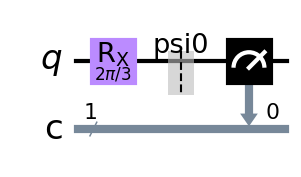

In [15]:
#======== Setup circuit
cir = qiskit.QuantumCircuit(1,1)  # make circuit
cir.rx (np.radians(120), 0)       # add gates
cir.save_statevector('psi0')      # save statevector (if desired)
cir.measure(0,0)                  # make measurements (if desired)
#======== Draw circuit
fig,ax = plt.subplots(figsize=(8,3))
cir.draw ('mpl',ax=ax)

In [26]:
#======== Run
sim = qiskit.Aer.get_backend('aer_simulator_statevector')   # set up simulator
exe = qiskit.transpile(cir,sim)   # compile
job = sim.run(exe)                # run
res = job.result()                # get result
#psi = res.get_statevector(cir)        # this doesn't work in general
psi = np.asarray(res.data() ['psi0'])  # workaround
cts = res.get_counts()

psi    = [0.5+0.j        0. -0.8660254j]


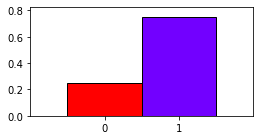

In [27]:
#======== Examine statevector after one run (the final run)
print (f'psi    = {psi}')
fig,ax = plt.subplots(figsize=(4,2))
plotStateVector(psi,ax=ax)

counts = {'0': 252, '1': 772}


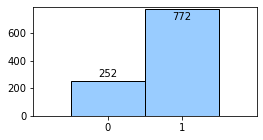

In [25]:
#======== Examine counts from 1000 runs: how many times did the measurement give '0' or '1'?
print (f'counts = {cts}')
fig,ax = plt.subplots(figsize=(4,2))
plotHistogram(cts,ax=ax)

<div class="alert alert-info"><h2>  Study effect of individual gates  </h2></div>

<div class="alert alert-warning"><h3>  Y-rotation gate $R_y(\theta)$  </h3></div>

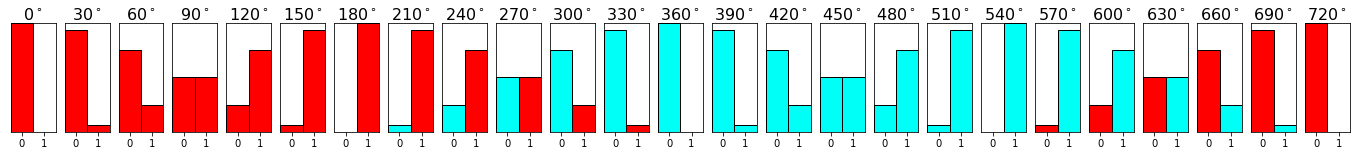

In [554]:
thetas = list(range(0,721,30))
fig,axs = plt.subplots(1, len(thetas), figsize=(24,2))
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
for i in range(len(thetas)):
  theta = thetas[i]; ax = axs[i]
  cir = qiskit.QuantumCircuit(1)                     # start with |0>
  cir.ry (np.radians(theta), 0)                      # apply R_y(theta)|psi>
  cir.save_statevector()                             # record |psi>
  psi = np.asarray(sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir))  # download psi
  plotStateVector(psi,ax=axs[i])
  ax.set_xlim (0,2); ax.set_ylim (0,1)
  ax.set_title (fr'${theta}^\circ$', fontsize=16,va='center',ha='center')
  ax.set_yticks ([])

A single-qubit rotation about the $y$-axis is represented by a $2\times 2$ rotation matrix.  Therefore, the effect of $R_y$  is to change the amplitudes of the |0> and |1> states.  Indeed we see this in the above visuzalizations of $\lvert\psi\rangle = R_y(\theta) \lvert 0\rangle$ for various $\theta$.  Note that a $360^\circ$ rotation corresponds to a global sign change, and a $720^\circ$ rotation is required to truly restore the identity!

$\hspace{1cm}$$\hat{R}_y(\theta)= \pmatrix{\cos\frac{\theta}{2}& -\sin\frac{\theta}{2}\\\sin\frac{\theta}{2}&\cos\frac{\theta}{2}}$
$\hspace{1cm}$$\therefore\hat{R}_y(\theta) \lvert 0\rangle = \cos\frac{\theta}{2} \lvert 0\rangle + \sin\frac{\theta}{2} \lvert 1\rangle$.



<div class="alert alert-warning"><h3>  X-rotation gate $R_x(\theta)$  </h3></div>

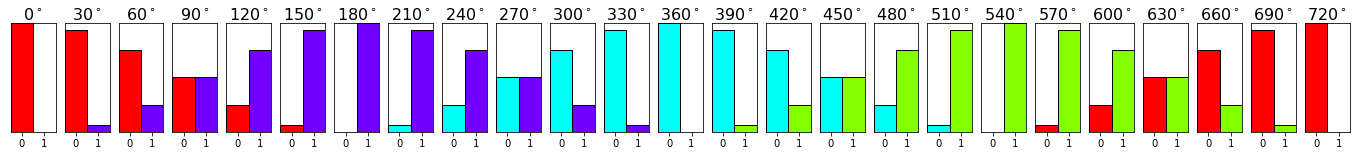

In [552]:
thetas = list(range(0,721,30))
fig,axs = plt.subplots(1, len(thetas), figsize=(24,2))
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
for i in range(len(thetas)):
  theta = thetas[i]; ax = axs[i]
  cir = qiskit.QuantumCircuit(1)                     # start with |0>
  cir.rx (np.radians(theta), 0)                      # apply R_x(theta)|psi>
  cir.save_statevector()                             # record |psi>
  psi = np.asarray(sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir))  # download psi
  plotStateVector(psi,ax=axs[i])
  ax.set_xlim (0,2); ax.set_ylim (0,1)
  ax.set_title (fr'${theta}^\circ$', fontsize=16,va='center',ha='center')
  ax.set_yticks ([])

Rotations about the X axis change both the amplitudes and phases.  Let's not discuss this.

<div class="alert alert-warning"><h3>  Z-rotation gate $R_z(\theta)$  </h3></div>

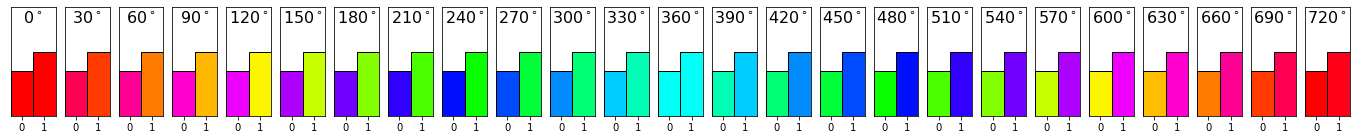

In [555]:
thetas = list(range(0,721,30))
fig,axs = plt.subplots(1, len(thetas), figsize=(24,2))
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
for i in range(len(thetas)):
  theta = thetas[i]; ax = axs[i]
  cir = qiskit.QuantumCircuit(1)
  cir.rx(np.radians(100),0); cir.p(np.radians(90),0) # initialize |psi> = a|0> + b|1>
  cir.rz (np.radians(theta), 0)                      # apply R_z(theta)|psi>
  cir.save_statevector()                             # record |psi>
  psi = np.asarray(sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir))  # download psi
  plotStateVector(psi,ax=axs[i])
  ax.set_xlim (0,2); ax.set_ylim (0,1)
  ax.text (1,.9, fr'${theta}^\circ$', fontsize=16,va='center',ha='center')
  ax.set_yticks ([])

The $R_z$ gate causes |0> to be multiplied by a certain phase factor, and |1> to evolve by the opposite phase factor.  Again, a $720^\circ$ rotation is required to get back to the identity.

$\hspace{1cm}$$\hat{R}_z(\theta)= \pmatrix{\exp \frac{i\theta}{2}& 0 \\ 0 & \exp \frac{-i\theta}{2}}$
$\hspace{1cm}$$\therefore\hat{R}_z(\theta) \lvert 0\rangle = \exp \frac{i\theta}{2} \lvert 0\rangle + \exp \frac{-i\theta}{2} \lvert 1\rangle$.



<div class="alert alert-warning"><h3>  Phase gate $P(\theta)$  </h3></div>

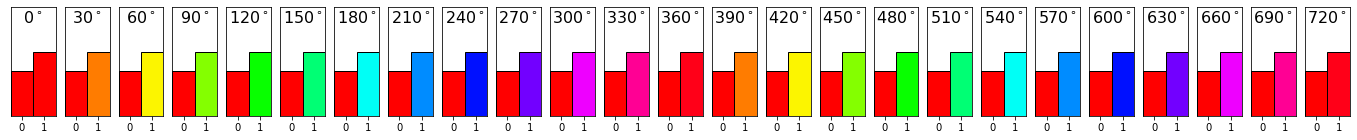

In [556]:
thetas = list(range(0,721,30))
fig,axs = plt.subplots(1, len(thetas), figsize=(24,2))
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
for i in range(len(thetas)):
  theta = thetas[i]; ax = axs[i]
  cir = qiskit.QuantumCircuit(1)
  cir.rx(np.radians(100),0); cir.p(np.radians(90),0) # initialize |psi> = a|0> + b|1>
  cir.p (np.radians(theta), 0)                       # apply P(theta)|psi>
  cir.save_statevector()                             # record |psi>
  psi = np.asarray(sim.run(qiskit.transpile(cir,sim)).result().get_statevector(cir))  # download psi
  plotStateVector(psi,ax=axs[i])
  ax.set_xlim (0,2); ax.set_ylim (0,1)
  ax.text (1,.9, fr'${theta}^\circ$', fontsize=16,va='center',ha='center')
  ax.set_yticks ([])

The figures above show $\lvert\psi\rangle = P(\theta) \lvert\psi\rangle$ for a certain $\lvert\psi\rangle$.  Note that |0> is unchanged whereas |1> picks up a phase factor.')
For the $P(\theta)$ gate, a $360^\circ$ rotation is the identity.

$\hspace{1cm}$$\hat{P}_z(\theta)= \pmatrix{1 & 0 \\ 0 & e^{i\theta}}$

$\hspace{1cm}$$\hat{P}_z(\theta) \lvert 0\rangle =  \lvert 0\rangle$

$\hspace{1cm}$$\hat{P}_z(\theta) \lvert 1\rangle =  e^{i\theta} \lvert 1\rangle$.



In [ ]:
from qiskit.visualization import plot_bloch_vector

plot_bloch_vector([0,1,0], title="New Bloch Sphere")

<div class="alert alert-info"><h2>  Measuring X, Y, and Z components of a qubit  </h2></div>

In [17]:
#=============================================================================
# Define quantum circuits to set up 1 qubit in |E>, |W>, |N>, |S>, |U>, or |D>
#=============================================================================
cirU = qiskit.QuantumCircuit(1)                                  # set |psi> = |Up>    = |0>
cirD = qiskit.QuantumCircuit(1); cirD.x(0)                       # set |psi> = |Down>  = |1>
cirE = qiskit.QuantumCircuit(1); cirE.h(0)                       # set |psi> = |East>  = |0> + |1> /sqrt(2)
cirW = qiskit.QuantumCircuit(1); cirW.x(0); cirW.h(0)            # set |psi> = |West>  = |0> - |1> /sqrt(2)
cirN = qiskit.QuantumCircuit(1); cirN.h(0); cirN.s(0)            # set |psi> = |North> = |0> + i|1> /sqrt(2)
cirS = qiskit.QuantumCircuit(1); cirS.x(0); cirS.h(0); cirS.s(0);# set |psi> = |South> = |0> - i|1> /sqrt(2)
sim = qiskit.Aer.get_backend('aer_simulator_statevector')
def finalState (cir):
  cir2 = cir.copy(); cir2.save_statevector()
  psi = np.asarray(sim.run(qiskit.transpile(cir2,sim)).result().get_statevector(cir2))
  return psi

In [18]:
#=============================================================================
# Print statevectors corresponding to |E>, |W>, |N>, |S>, |U>, and |D>
#=============================================================================
with np.printoptions(precision=2,suppress=True,floatmode='fixed',sign='+'):
  print ('|U> = ', finalState (cirU))
  print ('|D> = ', finalState (cirD))
  print ('|E> = ', finalState (cirE))
  print ('|W> = ', finalState (cirW))
  print ('|N> = ', finalState (cirN))
  print ('|S> = ', finalState (cirS))

|U> =  [+1.00+0.00j +0.00+0.00j]
|D> =  [+0.00+0.00j +1.00+0.00j]
|E> =  [+0.71+0.00j +0.71+0.00j]
|W> =  [+0.71+0.00j -0.71-0.00j]
|N> =  [+0.71+0.00j +0.00+0.71j]
|S> =  [+0.71+0.00j +0.00-0.71j]


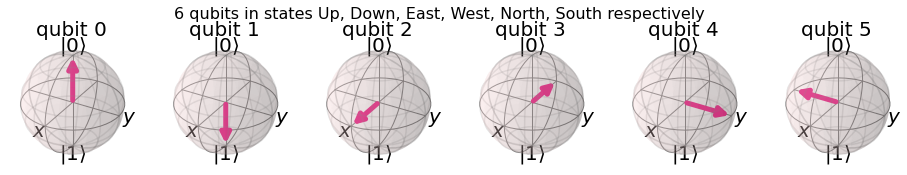

In [31]:
#=============================================================================
# Plot Bloch vectors corresponding to |E>, |W>, |N>, |S>, |U>, and |D>
#=============================================================================
cir = qiskit.QuantumCircuit(6) # set all qubits to |U> = |0>
cir.x(1)                       # set qubit 1 to |D>
cir.h(2)                       # set qubit 2 to |E>  = |0> + |1> /sqrt(2)
cir.x(3); cir.h(3)             # set qubit 3 to |W>
cir.h(4); cir.s(4)             # set qubit 4 to |N>
cir.x(5); cir.h(5); cir.s(5);  # set qubit 5 to |S>
qisvis.plot_bloch_multivector(finalState (cir), title='6 qubits in states Up, Down, East, West, North, South respectively')

In [35]:
#=============================================================================
# Define code to measure a qubit in the Z basis, the X basis, or the Y basis.
# To measure in the X basis, apply a Hadamard gate to rotate X to Z, then measure Z.
# To measure in the Y basis, apply an inverse S gate to rotate Y to X, then Hadamard X to Z, then measure Z.
#=============================================================================
cirZ = qiskit.QuantumCircuit(1,1); cirZ.measure(0,0)
cirX = qiskit.QuantumCircuit(1,1); cirX.h(0); cirX.measure(0,0)
cirY = qiskit.QuantumCircuit(1,1); cirY.p(-np.pi/2,0); cirY.h(0); cirY.measure(0,0)

def findCounts(cir):
  cir.draw('mpl')
  cts = sim.run(qiskit.transpile(cir,sim),shots=100).result().get_counts(cir)
  return cts
print ('|U> measured in X basis: ', findCounts(cirU.compose(cirX)))
print ('|U> measured in Y basis: ', findCounts(cirU.compose(cirY)))
print ('|U> measured in Z basis: ', findCounts(cirU.compose(cirZ)))
print ()
print ('|D> measured in X basis: ', findCounts(cirD.compose(cirX)))
print ('|D> measured in Y basis: ', findCounts(cirD.compose(cirY)))
print ('|D> measured in Z basis: ', findCounts(cirD.compose(cirZ)))
print ()
print ('|E> measured in X basis: ', findCounts(cirE.compose(cirX)))
print ('|E> measured in Y basis: ', findCounts(cirE.compose(cirY)))
print ('|E> measured in Z basis: ', findCounts(cirE.compose(cirZ)))
print ()
print ('|W> measured in X basis: ', findCounts(cirW.compose(cirX)))
print ('|W> measured in Y basis: ', findCounts(cirW.compose(cirY)))
print ('|W> measured in Z basis: ', findCounts(cirW.compose(cirZ)))
print ()
print ('|N> measured in X basis: ', findCounts(cirN.compose(cirX)))
print ('|N> measured in Y basis: ', findCounts(cirN.compose(cirY)))
print ('|N> measured in Z basis: ', findCounts(cirN.compose(cirZ)))
print ()
print ('|S> measured in X basis: ', findCounts(cirS.compose(cirX)))
print ('|S> measured in Y basis: ', findCounts(cirS.compose(cirY)))
print ('|S> measured in Z basis: ', findCounts(cirS.compose(cirZ)))

|U> measured in X basis:  {'1': 42, '0': 58}
|U> measured in Y basis:  {'1': 48, '0': 52}
|U> measured in Z basis:  {'0': 100}

|D> measured in X basis:  {'0': 44, '1': 56}
|D> measured in Y basis:  {'1': 51, '0': 49}
|D> measured in Z basis:  {'1': 100}

|E> measured in X basis:  {'0': 100}
|E> measured in Y basis:  {'0': 57, '1': 43}
|E> measured in Z basis:  {'0': 53, '1': 47}

|W> measured in X basis:  {'1': 100}
|W> measured in Y basis:  {'0': 50, '1': 50}
|W> measured in Z basis:  {'0': 48, '1': 52}

|N> measured in X basis:  {'1': 52, '0': 48}
|N> measured in Y basis:  {'0': 100}
|N> measured in Z basis:  {'1': 51, '0': 49}

|S> measured in X basis:  {'0': 54, '1': 46}
|S> measured in Y basis:  {'1': 100}
|S> measured in Z basis:  {'0': 52, '1': 48}


The state $\ket{U}\equiv\ket{0}$ measured in the Z basis always gives '0'.

The state $\ket{D}\equiv\ket{1}$ measured in the Z basis always gives '1'.

The state $\ket{E}\equiv \tfrac{1}{\sqrt{2}} (\ket{0}+\ket{1})$, measured in the Z basis, gives '0' or '1' with equal probability.  And so on.

<div class="alert alert-info" style="background-color: #FF9; border-color: #CC6;"><h2>  Suggested activities  </h2></div>

2.1.  Other single-qubit gates
- Look up the list of single-qubit gates provided by Qiskit.
- Build a circuit containing one of those gates that we have not seen yet (e.g., S or T).  
- Run the circuit.
- Print appropriate output to see how the gate changes the statevector.

2.2.  Two-qubit gates [I need to provide examples first]